# Bayesian inference with PyMC
## Truncated normal distribution for the likelihood

original version see https://github.com/JackCaster/Distribution_playground/blob/master/notebook/Truncated_normal_distribution.ipynb

In [1]:
import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(123)

import scipy.stats as st
import scipy.special as ss

import theano.tensor as tt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def normal_pdf(x, mu, sigma):
    return np.exp(-((x-mu)**2)/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + ss.erf((x-mu)/(sigma*np.sqrt(2))))

In [3]:
# The following functions are based on Wikipedia. 
# The drawback is that are not easily adaptable to other distributions
def normal_pdf_truncated(x, mu, sigma, upper):
    pdf = normal_pdf((x-mu)/sigma, 0, 1)
    Z = normal_cdf((upper-mu)/sigma, 0, 1)
    pdf /= (sigma * Z)
    
    return pdf

def normal_cdf_truncated(x, mu, sigma, upper):
    cdf = normal_cdf((x-mu)/sigma, 0, 1)    
    Z = normal_cdf((upper-mu)/sigma, 0, 1)
    cdf /= Z
    
    return cdf

In [4]:
# The following functions are based on the general approach to truncate distributions. 
# These can be easily adapted to other distributions
def normal_pdf_truncated_v2(x, mu, sigma, upper):
    pdf = normal_pdf(x, mu, sigma)
    pdf[x>upper] = 0
    
    pdf /= normal_cdf(upper, mu=mu, sigma=sigma)
    
    return pdf

def normal_cdf_truncated_v2(x, mu, sigma, upper):
    cdf = normal_cdf(x, mu, sigma)
    cdf[x>upper] = 0
    
    cdf /= normal_cdf(upper, mu=mu, sigma=sigma)
    
    return cdf

In [5]:
# generate Inverse Gaussian observations
mu = 0
sigma = 3

y_norm = np.random.normal(loc=mu, scale=sigma, size=10000)

range_x = 0.01
x_norm = np.arange(np.min(y_norm), np.max(y_norm), range_x)

upper = 5

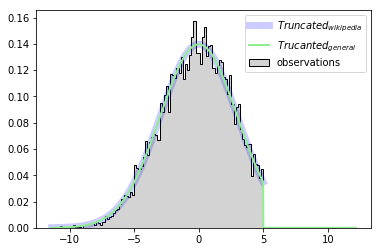

In [6]:
# Test if the function are working correctly
plt.hist(y_norm[y_norm<=upper], 
         bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k',
         label='observations')
plt.plot(x_norm[x_norm<=upper], normal_pdf_truncated(x=x_norm[x_norm<=upper], mu=mu, sigma=sigma, upper=upper), 
         'b-', alpha=0.2, lw=7, label='$Truncated_{wikipedia}$');
plt.plot(x_norm, normal_pdf_truncated_v2(x=x_norm, mu=mu, sigma=sigma, upper=upper), 
         color='lightgreen', alpha=1, lw=2, label='$Trucanted_{general}$');

plt.legend();

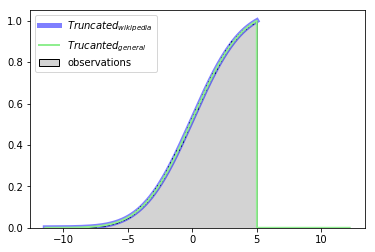

In [7]:
# Test the CDF
plt.hist(y_norm[y_norm<=upper], 
         bins=100, density=True, cumulative=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k',
         label='observations');
plt.plot(x_norm[x_norm<=upper], normal_cdf_truncated(x=x_norm[x_norm<=upper], mu=mu, sigma=sigma, upper=upper), 
         'b-', alpha=0.5, lw=5,
         label='$Truncated_{wikipedia}$');
plt.plot(x_norm, normal_cdf_truncated_v2(x=x_norm, mu=mu, sigma=sigma, upper=upper),
         color='lightgreen', alpha=1, lw=2,
         label='$Trucanted_{general}$');
plt.legend();

## Estimate parameter with PyMC3

In [8]:
obs = y_norm[y_norm<=upper]
obs

array([-3.25689181,  2.99203634,  0.84893549, ..., -1.41679924,
        1.7458931 ,  2.91183859])

In [26]:
def normal_lcdf(x, mu, sigma):
    z = (x - mu) / sigma
    return tt.switch(
        tt.lt(z, -1.0),
        tt.log(tt.erfcx(-z / tt.sqrt(2.)) / 2.) - tt.sqr(z) / 2.,
        tt.log1p(-tt.erfc(z / tt.sqrt(2.)) / 2.)
    )

In [27]:
with pm.Model() as model:
    
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfNormal('sd', sd=100)
    
    y_likelihood = pm.Normal('y_likelihood', mu, sd, observed=obs)
    # potential works the same as target +=... in Stan, tt.switch works the same as ifelse
    # see: https://discourse.pymc.io/t/truncated-inverse-normal-distribution-also-known-as-wald-distribution/1125
    upper_bound = pm.Potential('upper_bound', tt.switch(tt.gt(obs, upper), -np.inf, -normal_lcdf(upper, mu, sd)))
    
    trace = pm.sample(draws=5000, chains=2, cores=2, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
INFO:pymc3:NUTS: [sd_log__, mu]
100%|██████████| 6000/6000 [00:06<00:00, 918.63it/s]


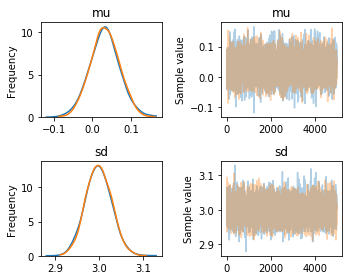

In [28]:
pm.traceplot(trace, figsize=(5, 4));

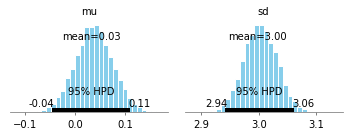

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
pm.plot_posterior(trace, color='skyblue', round_to=2, ax=ax);

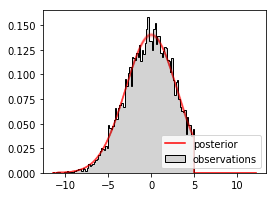

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.hist(obs, 
         bins=100, density=True, histtype='stepfilled', facecolor='lightgray', edgecolor='k',
         label='observations');

for mu, sigma in zip(trace['mu'][::100], trace['sd'][::100]):
    pdf = normal_pdf_truncated_v2(x_norm, mu, sigma, upper)
    plt.plot(x_norm, pdf, '-r', alpha=0.01)

plt.plot(np.nan, np.nan, '-r', label='posterior')
plt.legend();

In [24]:
stan_mdl = """
data { 
    int<lower=1> N;
    vector[N] y;
    real upper;
} 
parameters { 
    real mu; 
    real<lower=0> sd1;
}
model {
    sd1 ~ normal(0, 100); 
    mu ~ normal(0, 100); 
    target += normal_lpdf(y | mu, sd1);
    for (n in 1:N) {
    if (y[n] > upper) 
        target += negative_infinity();
    else
        target += -normal_lcdf(upper | mu, sd1);
    }
}
"""

In [ ]:
import pystan
stanfit  = pystan.stan(model_code=stan_mdl, data=dict(N=len(obs), y=obs, upper=upper), 
                       iter=3000, warmup=1000, chains=4, n_jobs=2,verbose=False)

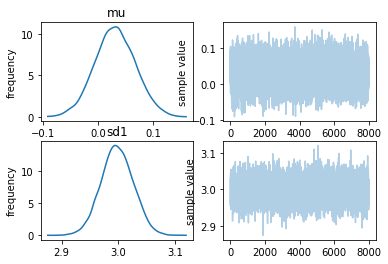

In [31]:
stanfit.plot()
plt.show()

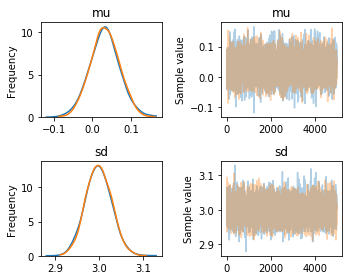

In [32]:
pm.traceplot(trace, figsize=(5, 4));

In [33]:
print(stanfit)

Inference for Stan model: anon_model_e75ebd755533898242b92607f5311136.
4 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     0.03  5.4e-4   0.04  -0.04 6.7e-3   0.03   0.06    0.1   4586    1.0
sd1     3.0  4.0e-4   0.03   2.94   2.98    3.0   3.02   3.05   4968    1.0
lp__ -2.3e4    0.02   0.95 -2.3e4 -2.3e4 -2.3e4 -2.3e4 -2.3e4   3890    1.0

Samples were drawn using NUTS at Tue Apr 24 12:08:46 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [35]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.03,0.04,0.0,-0.04,0.11,7163.83,1.0
sd,3.00,0.03,0.0,2.94,3.06,7597.36,1.0
